In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])

dataset = datasets.MNIST(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            # Input: (N, z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0),  # (N, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),     # (N, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),       # (N, 1, 28, 28)
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)  # reshape to (N, z_dim, 1, 1)
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Input: (N, 1, 28, 28)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),   # (N, 64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # (N, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0),  # (N, 1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, 1)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)

G.apply(weights_init)
D.apply(weights_init)

loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=2e-4)
optimizer_D = optim.Adam(D.parameters(), lr=2e-4)

epochs = 30
for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        
        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # --------------------
        # Train Discriminator
        # --------------------
        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = G(z)

        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())
        loss_D = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # ----------------
        # Train Generator
        # ----------------
        D_fake = D(fake_imgs)
        loss_G = loss_fn(D_fake, real_labels)  # Fool D → want labels = 1

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


Epoch 1/30 | Loss D: 0.0042, Loss G: 6.9461
Epoch 2/30 | Loss D: 0.1578, Loss G: 4.8145
Epoch 3/30 | Loss D: 0.1666, Loss G: 3.4833
Epoch 4/30 | Loss D: 0.2107, Loss G: 3.0427
Epoch 5/30 | Loss D: 0.9574, Loss G: 1.7580
Epoch 6/30 | Loss D: 0.5293, Loss G: 2.0907
Epoch 7/30 | Loss D: 0.3541, Loss G: 2.6725
Epoch 8/30 | Loss D: 0.5303, Loss G: 2.0199
Epoch 9/30 | Loss D: 0.3704, Loss G: 2.2636
Epoch 10/30 | Loss D: 0.2859, Loss G: 2.7641
Epoch 11/30 | Loss D: 0.2646, Loss G: 2.2656
Epoch 12/30 | Loss D: 0.4225, Loss G: 2.4938
Epoch 13/30 | Loss D: 0.6976, Loss G: 1.8416
Epoch 14/30 | Loss D: 0.4469, Loss G: 2.0029
Epoch 15/30 | Loss D: 0.3766, Loss G: 4.3061
Epoch 16/30 | Loss D: 0.3549, Loss G: 2.4286
Epoch 17/30 | Loss D: 0.3298, Loss G: 2.2932
Epoch 18/30 | Loss D: 0.6547, Loss G: 1.8854
Epoch 19/30 | Loss D: 0.5733, Loss G: 1.8999
Epoch 20/30 | Loss D: 0.3259, Loss G: 1.8351


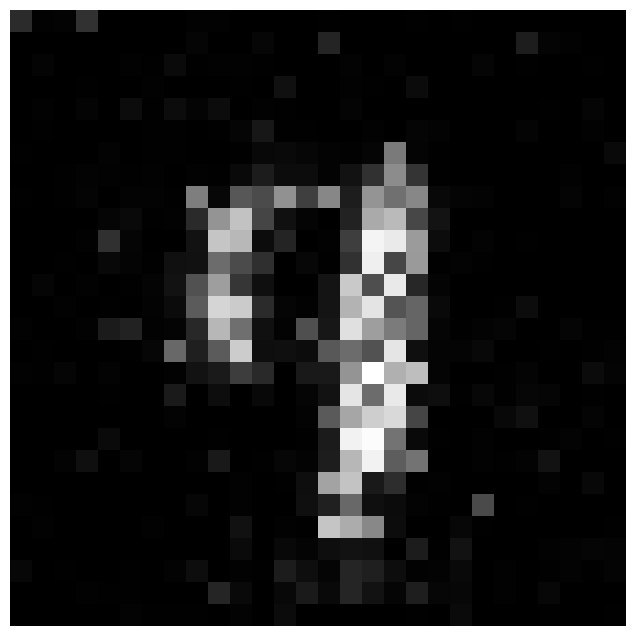

In [ ]:
def show_samples(generator, discriminator):
    generator.eval()
    discriminator.eval()
    z = torch.randn(1, 100).to(device)
    samples = generator(z).cpu().detach()
    print(discriminator.predict(samples))
    grid = np.transpose(torchvision.utils.make_grid(samples, nrow=8, normalize=True), (1, 2, 0))
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

show_samples(G, D)
